### Prompt Importance Calculation using SVC

In [6]:
import pandas as pd
import os
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 
import matplotlib.style as style
import seaborn as sns
from PIL import Image
# max size of pixel of image increase to 100000
Image.MAX_IMAGE_PIXELS = 1000000000
import pickle
# filter warnings
import warnings
warnings.filterwarnings("ignore")
input_dir = r"E:\KSA Project\dataset\paip_data\output\top3_prompts11_ReviwedSlides\top3_prompts_2cluster_top1_patch.csv"
output_dir = r"E:\KSA Project\dataset\paip_data\output\top3_prompts11_ReviwedSlides\svm_results"
AGGREGATION_METHOD = "mean"
os.makedirs(output_dir, exist_ok=True)

### Prompt Counts Summary

In [7]:
# read the file
df = pd.read_csv(input_dir)
# print the count of MSIH and nonMSIH from the label column
print(df["Label"].value_counts())
# separate the msih and nonmsih data
msih = df[df["Label"] == "MSIH"]
nonmsih = df[df["Label"] == "nonMSIH"]
# now in both count the unique count of best caption column
print(msih["Best_Caption"].nunique())
print(nonmsih["Best_Caption"].nunique())
# now we will count the best caption for each label
# print(f'Count of Patches against each promt in MSIH')
# print(msih["Best_Caption"].value_counts())
# print(f'Count of Patches against each promt in nonMSIH')
# print(nonmsih["Best_Caption"].value_counts())

Label
MSIH       130
nonMSIH    120
Name: count, dtype: int64
68
65


### SVM Training

In [8]:
# Load dataset
prompts_data = pd.read_csv(input_dir)

# Convert labels to binary format
prompts_data['Label'] = prompts_data['Label'].map({'MSIH': 1, 'nonMSIH': 0})
msi_GT = prompts_data['Label'].to_numpy(dtype=int)

# Extract patient IDs from WSI_Id
patients = prompts_data['WSI_Id'].tolist()
patients_unique = np.unique(np.array(patients))

# Extract probability scores from Prompt columns
prompt_cols = [col for col in prompts_data.columns if 'Prompt' in col]
# Extract features for training
Fn = prompts_data[prompt_cols].to_numpy(dtype=np.float32)

if AGGREGATION_METHOD == "mean":
    probs = prompts_data[prompt_cols].mean(axis=1).tolist()  # Averaging all prompt scores
    Fn = (Fn + 1) / 2
else:
    probs = prompts_data[prompt_cols].median(axis=1).tolist()  # Median of all prompt scores

# Initialize lists for ranking and processing
tiles_pat_ranks = []
tiles_ranks = []
patient_ids = []
pid = 0

for pat in patients_unique:
    indices = prompts_data[prompts_data['WSI_Id'] == pat].index.tolist()
    tiles_pat_probs = np.array([probs[i] for i in indices])
    ranks = np.argsort(1 - tiles_pat_probs)
    tiles_ranks.extend(ranks)
    patient_ids.extend([pid] * len(indices))
    pid += 1

# Create a DataFrame with required fields
df = pd.DataFrame({
    'WSI-ID': prompts_data['WSI_Id'],
    'TrueLabel': prompts_data['Label'],
    'Prediction_Score': probs
})

L = prompts_data['Label'].to_numpy(dtype=np.float32)
# Split indices for positive and negative samples
pidx = np.nonzero(L == 1)[0]
nidx = np.nonzero(L == 0)[0]

W = []
A = []
p = 0.75  # Train-test split ratio

for _ in range(150):
    np.random.shuffle(pidx)
    np.random.shuffle(nidx)
    idx = list(set(pidx[:int(p * len(pidx))])) + list(set(nidx[:int(p * len(nidx))]))
    clf = LinearSVC(C=10, class_weight='balanced', max_iter=1700).fit(Fn[idx, :], L[idx])
    Y = clf.decision_function(Fn[idx, :])
    w = clf.coef_.flatten()
    w = w / np.linalg.norm(w)
    a = roc_auc_score(L[idx], Y)
    A.append(a)
    W.append(w)

W = np.array(W)

# also save mean and std of feature weights to a csv file
feat_stats = pd.DataFrame({
    'Feature': prompt_cols,
    'Mean': np.mean(W, axis=0),
    'Std': np.std(W, axis=0)
})
feat_stats.to_csv(os.path.join(output_dir, f'{AGGREGATION_METHOD}_feat_imp_stats.csv'), index=False)

# Save feature importance results
feat_imp = pd.DataFrame(W, columns=prompt_cols)
feat_imp.to_excel(os.path.join(output_dir, f'{AGGREGATION_METHOD}_feat_imp_alliters.xlsx'), index=False)
feat_imp.head()

,Prompt_1,Prompt_2,Prompt_3,Prompt_4,Prompt_5,Prompt_6,Prompt_7,Prompt_8,Prompt_9,Prompt_10,Prompt_11
0,0.617956,-0.384305,-0.174280,0.261481,-0.052583,-0.184611,-0.462966,0.314025,0.119420,-0.069843,-0.052538
1,0.704626,-0.253442,-0.130897,0.187767,-0.134399,-0.137724,-0.479468,0.338667,-0.004980,-0.049366,-0.052923
2,0.582937,-0.368909,-0.050204,0.078540,0.028442,0.002066,-0.484318,0.497287,-0.110978,-0.053166,-0.132618
3,0.628104,-0.414892,-0.065496,0.058578,0.116844,-0.021919,-0.522460,0.324045,0.039426,-0.049264,-0.171890
4,0.635459,-0.332449,-0.308197,0.255615,0.030271,-0.064650,-0.418333,0.243806,0.073406,-0.260459,0.112153


### Visualisation

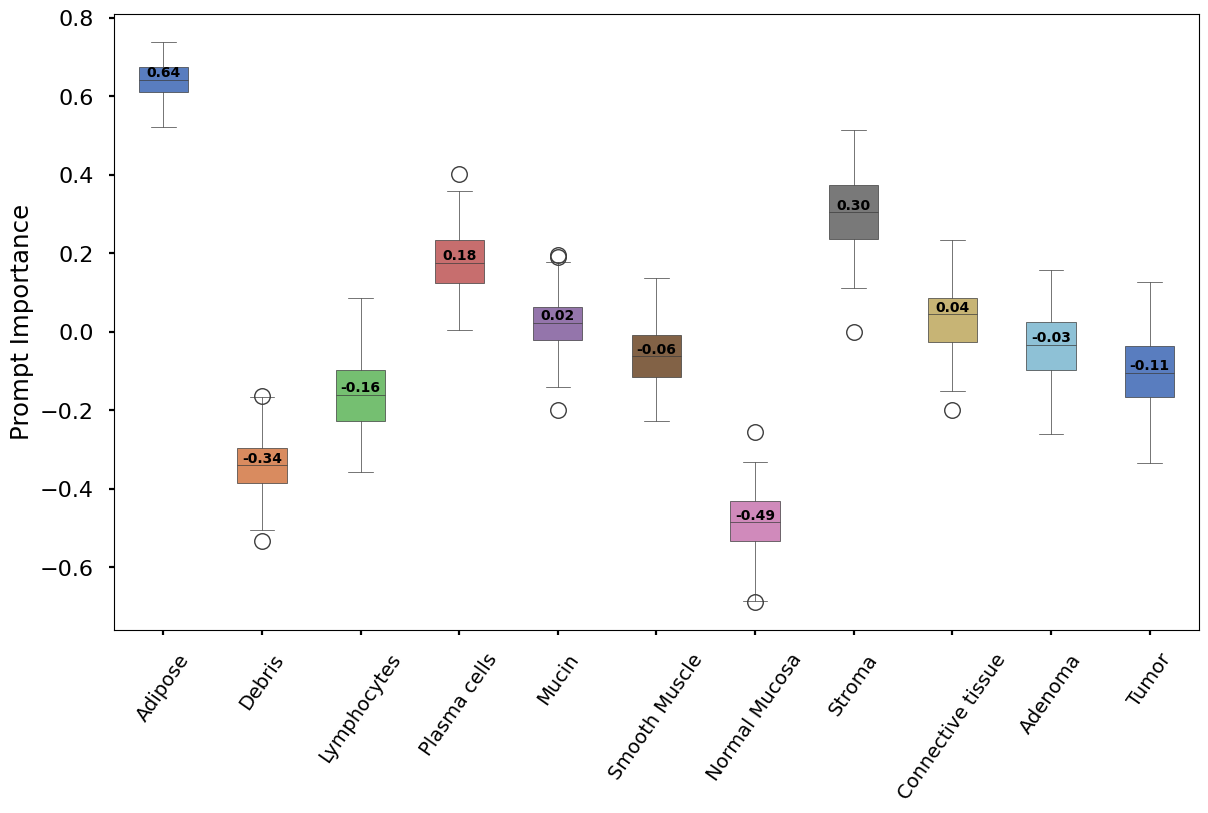

In [9]:
# Load feature importance data
feat_imp = os.path.join(output_dir, f'{AGGREGATION_METHOD}_feat_imp_alliters.xlsx')

df_feat_imp = pd.read_excel(feat_imp)
# describe the data
prompt_class = ["Adipose",
    "Debris",
    "Lymphocytes",
    "Plasma cells",
    "Mucin",
    "Smooth Muscle",
    "Normal Mucosa",
    "Stroma",
    "Connective tissue",
    "Adenoma",
    "Tumor"]
# column names are prompt numbers so we need to rename them to prompt names so check if prompt in the column name
# if yes then replace it with the prompt name, no fix size loop keep it df.col length and replace it with prompt_class
df_feat_imp.columns = [prompt_class[int(col.split('_')[-1]) - 1] if 'Prompt' in col else col for col in df_feat_imp.columns]
# melt the data
dd = pd.melt(df_feat_imp, 
             var_name='Feature', 
             value_name='Importance')

# Set visualization style
style.use('seaborn-v0_8-poster')

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create box plot
g = sns.boxplot(x='Feature', y='Importance',
                linewidth=0.5,
                width=0.5,
                palette='muted',
                data=dd, ax=ax)

# Add text labels for each boxplot
for i, feature in enumerate(dd['Feature'].unique()):
    median_val = dd[dd['Feature'] == feature]['Importance'].median()
    ax.text(i, median_val, f'{median_val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylim()
# Adjust labels and title
ax.set_ylabel('Prompt Importance')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, fontsize=14)

# Save in the output directory
plt.savefig(f'{output_dir}/{AGGREGATION_METHOD}_feat_imp_boxplot.png', format='png', dpi=500, bbox_inches='tight')
# plt.savefig('files/feat_imp_boxplot.pdf', format='pdf', dpi=600)
# plt.savefig('files/feat_imp_boxplot.eps', format='eps', dpi=600)
# Show plot
plt.show()
plt.close()

### Plot HeatMap of the Prompts

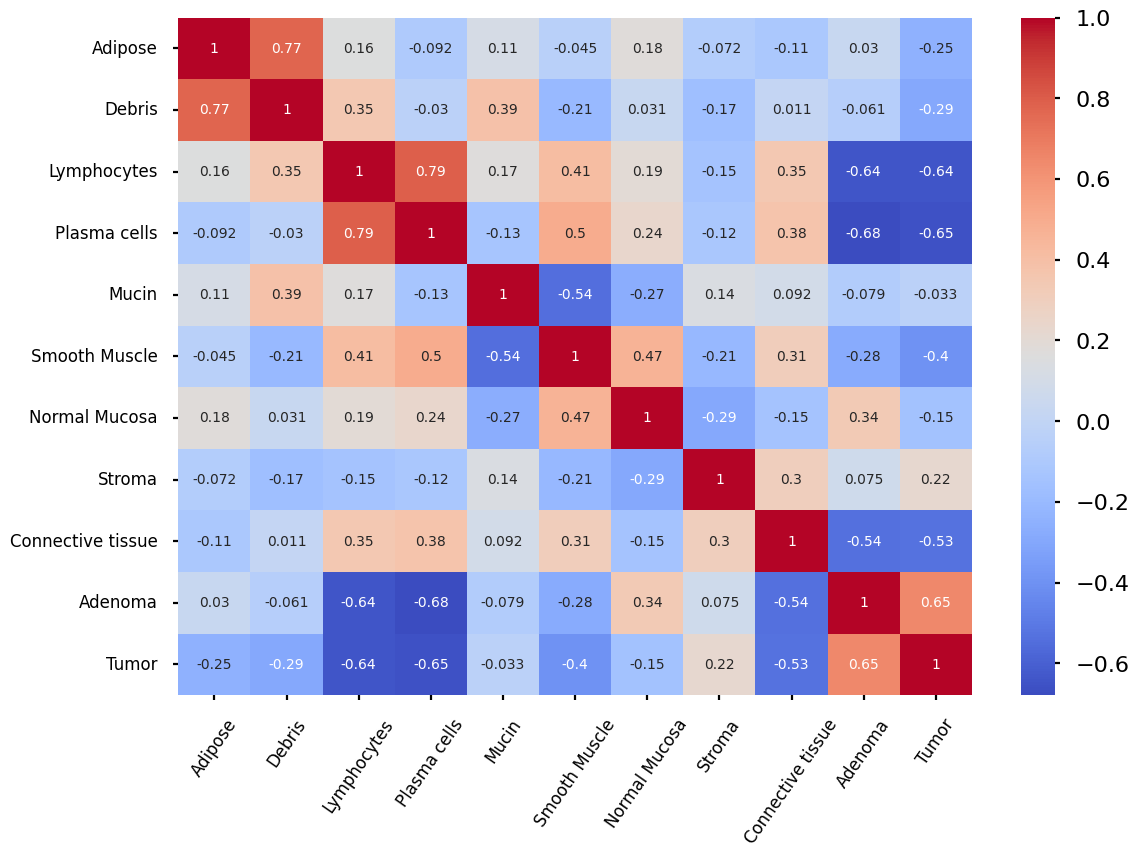

In [10]:
prompts_data = pd.read_csv(input_dir)
prompt_cols = [col for col in prompts_data.columns if 'Prompt' in col]
F = prompts_data[prompt_cols].to_numpy(dtype=np.float32)
corr_matrix = pd.DataFrame(F, columns=prompt_class).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
# rotate the x axis labels
plt.xticks(rotation=55, fontsize=12)
# y axis labels size
plt.yticks(fontsize=12)
# save the plot                                                                                                                                                                                                                             
plt.savefig(f'{output_dir}/{AGGREGATION_METHOD}_prompts_corr_matrix.png', format='png', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

### Feature Importance Hirerchical Clustering

<Figure size 1200x1000 with 0 Axes>

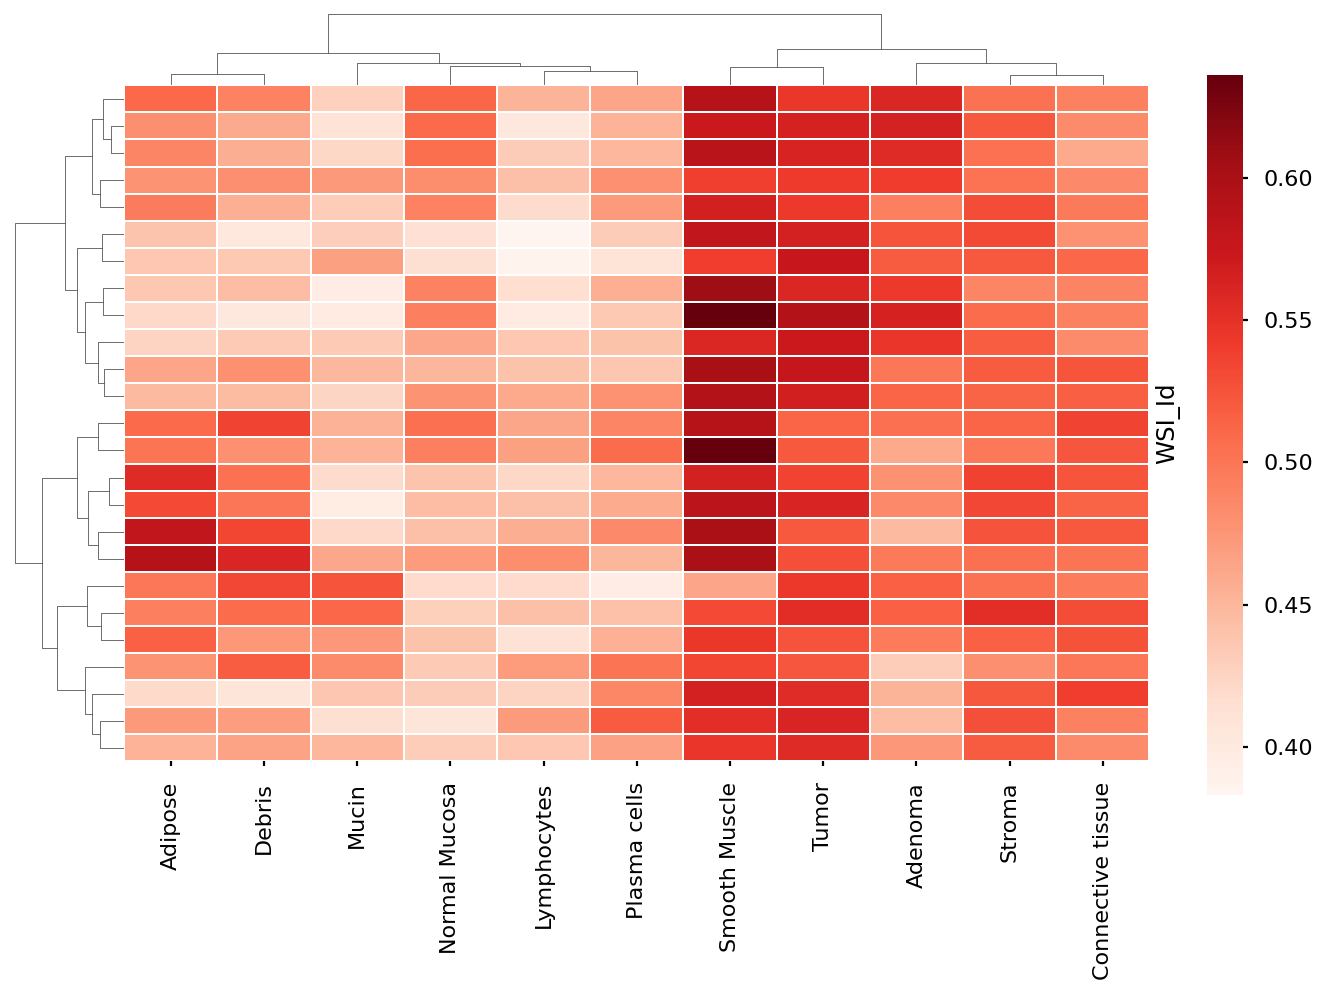

In [ ]:
# Load the dataset (update the path)
df = pd.read_csv(input_dir)

prompt_cols = [col for col in df.columns if 'Prompt' in col]
prompt_class = ["Adipose",
    "Debris",
    "Lymphocytes",
    "Plasma cells",
    "Mucin",
    "Smooth Muscle",
    "Normal Mucosa",
    "Stroma",
    "Connective tissue",
    "Adenoma",
    "Tumor"]

# Convert prompts to numeric (if necessary)
df[prompt_cols] = df[prompt_cols].apply(pd.to_numeric, errors='coerce')

# Aggregate feature importance at the patient level (taking the mean of prompt scores per WSI_Id)
if AGGREGATION_METHOD == "mean":
    patient_df = df.groupby("WSI_Id")[prompt_cols].mean()
    patient_df = (patient_df + 1) / 2
else:
    patient_df = df.groupby("WSI_Id")[prompt_cols].median()

df['WSI_Label'] = df['WSI_Id'].astype(str).apply(lambda x: 0 if 'nonmsih' in x.lower() else 1)
wsi_label_mapping = df.set_index("WSI_Id")["WSI_Label"].to_dict()  # Mapping for relabeling y-axis
patient_df.columns = prompt_class
patient_df.index = patient_df.index.map(lambda x: wsi_label_mapping[x])  # Replace WSI_Id with labels

# Create a hierarchical clustering heatmap
plt.figure(figsize=(12, 10))
g = sns.clustermap(
    patient_df,
    method="ward",  # Hierarchical clustering method
    cmap="Reds",  # Color scheme similar to the reference image
    figsize=(12, 10),
    linewidths=0.2,  # Add slight grid lines for clarity
    xticklabels=True,  # Show patient IDs clearly on the X-axis
    yticklabels=False,  # Show prompt names on the Y-axis
    dendrogram_ratio=(0.1, 0.1),  # Adjust dendrogram size for better clarity
    cbar_pos=(1.01, 0.20, 0.03, 0.72)  # Adjust color bar position
)

# Improve y-axis label visibility
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=5, color='black', weight='bold',rotation=90)
g.ax_heatmap.tick_params(axis='y', length=0)  # Remove ticks to declutter
g.ax_heatmap.yaxis.set_tick_params(pad=5)     # Add padding from axis
# save the plot
plt.savefig(f'{output_dir}/{AGGREGATION_METHOD}_biCluster.png', format='png', dpi=500, bbox_inches='tight')
plt.show()
plt.close()
### SVM classifier ###